In [1]:
import tiktoken
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from openai import OpenAI
from tqdm import tqdm


100%|██████████| 7541/7541 [00:05<00:00, 1495.81it/s]


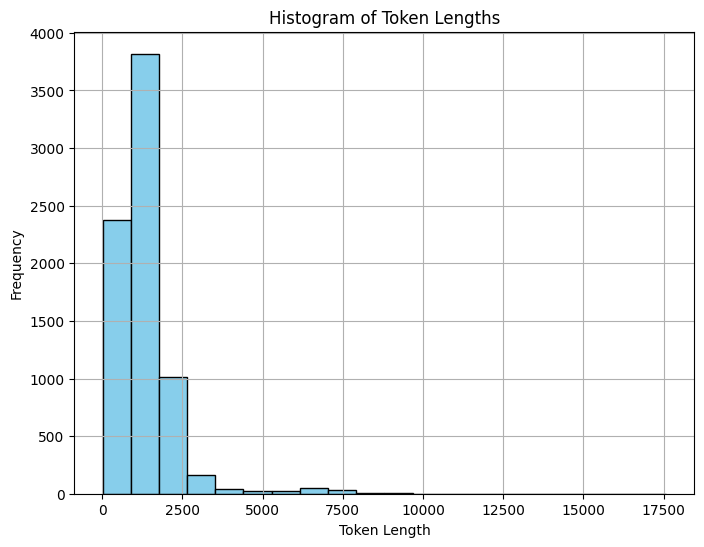

In [2]:
encoding = tiktoken.encoding_for_model("text-embedding-3-large")

input_excel = './data/paper_pro.xlsx'
df = pd.read_excel(input_excel)
file_content_dict = dict(zip(df['File Name'], df['Content']))
token_length = []
for k, v in tqdm(file_content_dict.items(), total=len(file_content_dict)):
    tokens = encoding.encode(v)
    token_length.append(len(tokens))
token_length = np.array(token_length)
    
plt.figure(figsize=(8, 6))
plt.hist(token_length, bins=20, edgecolor='black', color='skyblue')
plt.title('Histogram of Token Lengths')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [3]:
data = []
num_truncated = 0
for k, v in tqdm(file_content_dict.items(), total=len(file_content_dict)):
    tokens = encoding.encode(v)
    if len(tokens) > 8192:
        tokens = tokens[:8192]
        truncated_content = encoding.decode(tokens)
        data.append([k, truncated_content])
        num_truncated += 1
    else:
        data.append([k, v])
print(f'{num_truncated} papers have been truncated')
df = pd.DataFrame(data, columns=['File Name', 'Content'])
output_excel = './data/paper_pro_truncated.xlsx'
df.to_excel(output_excel, index=False)

100%|██████████| 7541/7541 [00:04<00:00, 1599.56it/s]


7 papers have been truncated


In [ ]:
input_excel = './data/paper_pro_truncated.xlsx'
df = pd.read_excel(input_excel)
samples = list(zip(df['File Name'], df['Content']))

client = OpenAI(api_key='')
n_split = 100
n_size = len(samples) // n_split + 1
embeddings = []
for i in tqdm(range(n_split)):
    batch = []
    names = []
    for sample in samples[i*n_size:(i+1)*n_size]:
        batch.append(sample[1])
        names.append(sample[0])
    response = client.embeddings.create(
        input=batch,
        model="text-embedding-3-large"
    )
    for idx, name in enumerate(names):
        np.save(f'./data/paper_emb_openai/{name}.npy',response.data[idx].embedding)

100%|██████████| 100/100 [11:51<00:00,  7.12s/it]
